# *Notebook #1* - First application: GPUs, CUDA, and Python + Numba


## Introduction

*This is the first out of three notebooks aimed at introducing you to the core concepts of graphics processing units (GPUs) and walking you through the basics of general-purpose computing on GPUs (GPGPU).*

Compared to a CPU, a GPU excells in procesing a large number of instructions simultaneously. Its **large amount of processing cores** gives it the ability to execute several thousand, if not million, threads in **parallel**. Using the right tools and correct reasoning during application design, this can yield a greater instruction througput, and decrease the time delay for processing large datasets. Be it images (video frames), elecric signal measurements, or any other domain-specific information.

<!-- ![GPU vs CPU](./Image/gpu-vs-cpu.png){ width="100px"} -->
<img src="./Image/gpu-vs-cpu.png" alt="GPU vs CPU" style="width: 750px; padding: 20px"/>

Whether an AMD, ARM, a Qualcomm, or any other GPU can probably be interfaced using OpenGL/OpenCL, this course is structured around Nvidia GPUs and the CUDA API.



### CUDA

Owing to the efforts made by Nvidia, several open-source communities, and a broad userbase, you can interface Nvidia GPUs through the CUDA API using **a host of programming languages**. All of this makes it easy to start writing and executing parallel code. You can think of the GPU as a step between a CPU and an FPGA - execute lots of instructions in parallel, but you get to stay within the comfort zone of your beloved IDE and programming language.

<img src="./Image/cuda-programming-languages.png" alt="Programming languages with CUDA support." style="width: 750px; padding: 20px"/>



### GeForce GT 730

You will be using the GeForce GT 730 model, which you verify check by calling `nvidia-smi` in the terminal. It is based on the Kepler architecture and supports compute capability 3.5. Keep this in mind when debugging and looking up the specs of you GPU.


### Python + Numba

Versatile and with lots of available add-ons, Python is growing in popularity accross various sectors, including GPGPU. Being an interpreted language, it's easy to run over and over again, while the **debugging** capabilities of IDEs such as **Pycharm**, and the available **plotting** libraries make it easy to interpret and present the performance of you application.

Since CUDA was initially intended for C, C++, and Fortran application, we need to fit an **additional compiler** between Python and CUDA. For that purpose we will be using **Numba** - a straightforward Python compiler. It's best to get familiar with it on an example.



### Jupyter Notebook

The document you are looking at is called a Jupyter Notebook. It's used for writing and running Python applications from the browser. You can always start a fresh file by clicking `File > New Notebook > Python 3`.
It should regularly save you file, but feel free to do so manually every once in a while. 

Supposing you are running Jupyter Notebooks using Anaconda and the GCA environment, your can also write and run your code from a Notebook, instead of in an IDE (Pycharm), and get the same results.

## Calculating the histogram of a sampled signal

To get acquainted with GPU programming, we will define a function that calculates the histogram of a sampled signal using parallel processing. We start off by implementing the desired funciton on the CPU, which will serve us as the baseline for evaluating the performance of the GPU.

### Define and plot the input signal

First define the sampled signal a plot it:

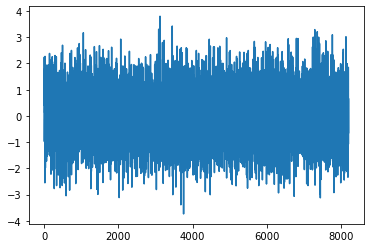

In [1]:
import numpy as np # Arrays in Python
from matplotlib import pyplot as plt # Plotting library

# Repeatable results
np.random.seed(0)

# Define the observed signal
signal = np.random.normal(size=8_192, loc=0, scale=1).astype(np.float32)

# Plot the signal
plt.plot(signal)
plt.show()

### CPU: Calculate the histogram

Next we define a CPU function and use it to calculate the histogram of the above signal:

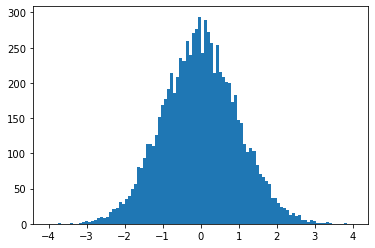

In [2]:
def calc_histogram_on_cpu(samples, xmin, xmax, histogram_out):
    '''Use the CPU to generate a histogram of the sampled signal within the defined boundries.
    
    The resulting histogram will contian the following values: [xmin, xmax)
    
    :param x: Observed signal.
    :param xmin: Minimal observed value contained in the histogram.
    :param xmax: Maximal observed value contained in the histogram.
    :param histogram_out: The calculated histogram.
    '''
    
    # Calc the resolution of the histogram
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins

    # Associate each sample in the interval [xmin, xmax) with a bin and update the histogram. Skip outliers.
    for sample in samples:
        bin_number = int((sample - xmin ) / bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            histogram_out[bin_number] += 1


# Define the range
xmin = -4
xmax = 4

# Number of histogram elements = bins
nbins = 100

# Initiate an empty histogram
histogram_out = np.zeros(nbins)

# Note: the histogram array is passed by reference and updated in the function
calc_histogram_on_cpu(signal, xmin, xmax, histogram_out)


# Calculate x-axis values for plotting reasons (we also need to recalculate the bin width)
bin_width = (xmax - xmin) / nbins
x_vals = np.linspace( xmin, xmax, nbins, endpoint=False ) + bin_width/2

# Plot the histogram
plt.bar( x_vals, histogram_out, width=bin_width )
plt.show()

### Timing the kernel function

An important aspect of evaluating the performance of our code will be measuring its execution time. Running our code within an OS also means that the execution time isn't entirelly deterministic. We can use the built-in IPython (Jupyter Notebook) timing function which gives us some flexibility in how many times and in what way we can time our functions:

In [3]:
%timeit calc_histogram_on_cpu(signal, xmin, xmax, histogram_out)

26.3 ms ± 753 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### GPU: Calculate the histogram

The CPU calculated the histogram faster than saying *Geavanceerde computerarchitectuur*, but a lot of deadlines would be violated if we ran it in a real-time app. Let's look at ways of improving the execution speed by porting the code to a GPU.

For that we need to define a **kernel**. Merely a function that is run on the GPU, a kernel is executed by a single thread. At this stage we also need to start using Numba in order to compile the kernel before running it on the GPU. To highlight this, we've switched to manual execution timing.

In [4]:
import time

from numba import cuda


@cuda.jit
def kernel(samples, xmin, xmax, histogram_out):
    '''Use the GPU for generateing a histogram.'''

    # Calc the resolution of the histogram
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins

    # Associate each sample in the interval [xmin, xmax) with a bin and update the histogram. Skip outliers.
    for sample in samples:
        bin_number = int((sample - xmin) / bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            cuda.atomic.add(histogram_out, bin_number, 1)


# Reset histogram back to zero
histogram_out = np.zeros(nbins)

# Call and time the kernel function
start = time.time()
kernel[1,1](signal, xmin, xmax, histogram_out)
print(time.time() - start)

# Repeat (copy-paste)
start = time.time()
kernel[1,1](signal, xmin, xmax, histogram_out)
print(time.time() - start)

NvvmError: Failed to compile

<unnamed> (45, 17): parse expected binary operation in atomicrmw
NVVM_ERROR_COMPILATION

Wait, the GPU is first horribly slow before outrunning the CPU? 

Executing the kernel function multiple times reveals a peak in the delay the first time since, unlike C, it isn't compiled-once-run-multiple-times, but it gets re-compiled everytime we run our code. Keep note of that when evaluating the performance of your code.

The line containing the `@cuda.jit` decorator signals Numba that this is a compilable GPU kernel.

### Executing threads parallel

If you've noticed, the above GPU-code iterates all signal samples **in sequence**, one after the other. That means we're only executing the kernel in a single thread. Actually, the extra bit between the function name and its arguments (`[1,1]`) defines that.

The CUDA API grants the developer access to a pool of **threads** organized into blocks. Each **block** can have up to three dimensions, and the blocks themselves can are organized in a **grid** which can also span 3D. 

<img src="./Image/Threads-and-blocks.png" alt="Threads and blocks" style="width: 400px; padding: 20px"/>

Ideally, we would like break our input sequence into as many separate segments as possible, and run each of them in its own thread. With that in mind, let's see how to improve our kernel. For simplicity, we'll only be using one dimension in te following example.

With a few minor modifications, we now run the kernel using 16 blocks of 512 blocks, giving us a total of 8192 threads - the sam number as the amount of signal samples. Because the same kernel function gets executed on each one of the parallel threads, we can now avoid looping over the samples and instead **only use the sample with the same index as that of the thread**. The statement `x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x` calculates the thread's index within the entire grid.

In [ ]:
import time

from numba import cuda


@cuda.jit
def kernel_parallel(samples, xmin, xmax, histogram_out):
    '''Use the GPU for generateing a histogram. In parallel.'''

    # Calculate the thread's absolute position within the grid
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Calc the resolution of the histogram
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    sample = samples[x]

    # Associate each sample in the interval [xmin, xmax) with a bin and update the histogram. Skip outliers.
    bin_number = int((sample - xmin) / bin_width)
    if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            cuda.atomic.add(histogram_out, bin_number, 1) # Prevent race conditions


start = time.time()
kernel_parallel[16,512](signal, xmin, xmax, histogram_out)
print(time.time() - start)

start = time.time()
kernel_parallel[16,512](signal, xmin, xmax, histogram_out)
print(time.time() - start)

Should be an improvement; although, to get a true comparison we need to run the two kernels several times. Because we **do not want to overload the system** and, potentially see how our computer freezes, we will define our own timing function which always waits for the kernel to finish before calling it again. This is called **synchronization**.

A similar thing happens within the kernel in the line containing `cuda.atomic.add(histogram_out, bin_number, 1)`. Normally we could just write `histogram_out[bin_number] += 1`, which would triger the following operations:
1. Get the current value `histogram_out[bin_number]`
2. Increment the value you've just read (` += 1`)
3. Write back to `histogram_out[bin_number]`

Then when two threads run in parallel, but out of phase, they start to overwrite the results of one another and we start seeing *race conditions*. We use `cuda.atomic.add()` to prevent that by executing the above 3 steps in sequence.

In [ ]:
def synchronous_kernel_timeit( kernel, number=1, repeat=1 ):
    """Time a kernel function while synchronizing upon every function call.

    :param kernel: Lambda function containing the kernel function (including all arguments)
    :param number: Number of function calls in a single averaging interval
    :param repeat: Number of repetitions
    :return: List of timing results or a single value if repeat is equal to one
    """

    times = []
    for r in range(repeat):
        start = time.time()
        for n in range(number):
            kernel()
            cuda.synchronize() # Do not queue up, instead wait for all previous kernel launches to finish executing
        stop = time.time()
        times.append((stop - start) / number)
    return times[0] if len(times)==1 else times


t_seq = synchronous_kernel_timeit( lambda: kernel[1,1](signal, xmin, xmax, histogram_out), number=10)
t_par = synchronous_kernel_timeit( lambda: kernel_parallel[16,512](signal, xmin, xmax, histogram_out), number=10)

print( t_seq )
print( t_par )


Great, it pays to run multiple threads! Lastly let's plot all three histograms and check that the results match.

In [ ]:
funs = [
    lambda x: calc_histogram_on_cpu(signal, xmin, xmax, x),
    lambda x: kernel[1,1](signal, xmin, xmax, x),
    lambda x: kernel_parallel[16,512](signal, xmin, xmax, x)
]

fig, ax = plt.subplots(1, 3, sharey=True)

for i, fun in enumerate(funs):
    histogram_out = np.zeros(nbins)
    fun(histogram_out)
    ax[i].plot( x_vals, histogram_out )
    

Nice! Now design your very own kernel and evaluate its performance.

## Assignment - Calculating a DFT

### Baseline and helpers

You have implemented a DFT function based on its definition:


$X_k = \sum_{n=0}^{N-1} x_n \cdot ( \cos{ \frac{2\pi kn}{N} } - i \sin{ \frac{2\pi kn}{N} } )$


It's not the most efficient piece of code so you want to optimize it by employing a GPU. Below is the CPU-based code, together with some other definitions to help you get an idea of how you can test the performance of your design.

In [ ]:
from math import sin, cos, pi


def DFT_sequential(samples, frequencies):
    """Execute the DFT sequentially on the CPU.
    
    :param samples: An array containing discrete time domain signal samples.
    :param frequencies: An empty array where the frequency components will be stored.
    """
    
    for k in range(frequencies.shape[0]):
        for n in range(N):
            frequencies[k] += samples[n] * ( cos( 2*pi * k * n / N ) - sin( 2*pi * k * n / N )*1j )
            

Now we supply the sequential funciton with an the input signal and measure the execution time. As a prerequisite, we first need to define the sampling rate and observation time. The input signal in this case is a sum of sinusoids with an added DC component.

In [ ]:
# Define the sampling rate and observation time
SAMPLING_RATE_HZ = 100
TIME_S = 5 # Use only integers for correct DFT results
N = SAMPLING_RATE_HZ * TIME_S


# Define sample times
x = np.linspace(0, TIME_S, int(N), endpoint=False)

# Define a group of signals and add them together
sigs = [ np.sin(x * (2*pi) * (i+1) * 2 + i*pi/16) / (i+1) for i in range(24) ]
sig_sum = np.array(sum(sigs) / len(sigs)) + 0.05


# Initiate the empty frequency components
frequencies = np.zeros(int(N/2+1), dtype=np.complex)


# Time the sequential CPU function
t = synchronous_kernel_timeit( lambda: DFT_sequential(sig_sum, frequencies), number=10 )
print(t)


That gives us the baseline that we wish to improve. When designing you code, feel free to experiment with other input waveforms, sampling rates, and observation times. Lastly we plot the results to check that the code functions as expected.

In [ ]:
# Reset the results and run the DFT
frequencies = np.zeros(int(N/2+1), dtype=np.complex)
DFT_sequential(sig_sum, frequencies)


# Plot to evaluate whether the results are as expected
fig, (ax1, ax2) = plt.subplots(1, 2)

# Calculate the appropriate X-axis for the frequency components
xf = np.linspace(0, SAMPLING_RATE_HZ/2, int(N/2+1), endpoint=True)

# Plot all of the signal components and their sum
for sig in sigs:
    ax1.plot( x, sig, lw=0.5, color='#333333', alpha=0.5 )
ax1.plot( x, sig_sum )

# Plot the frequency components
ax2.plot( xf, abs(frequencies), color='C3' )

plt.show()

### Report and deadline

*Follow the bellow insructions and write a report when done. Explain what you have learned and critically assess the performance of your code. The report shouldn't exceed 3 pages (including figures). If you wish to share your code, include a link to the corresponding repository in your report or write the report in the form of a Notebook.*

*Hand in your reports to alexander.marinsek@kuleuven.be by:*
* *SA & GS: Sunday, 28/02/2021, 23:59 CET*
* *ES: Sunday, 07/03/2021, 23:59 CET*


### Instructions

##### I. Implement your first CUDA kernel in Python

1. Design a kernel function for calculating the DFT of a signal. Start off with the sequential code and accelerate it by omiting one of the *for loops*. Rely on parallel execution instead.
2. Call your kernel function and verify its output. Use the same amount of threads as is the number of output frequency components. Start off with a few hundred signal samples. Keep in mind the limit of 1024 threads / block.
3. Increase the DFT resolution and with it the number of parallel threads. Does an upper limit exist? If there you can't reach it (long prrocessing times, etc.) then reason about what the limit might be (take a look at the 3.5 compute capability specs on Wikipedia / Nvidia guide).


##### II. Timing your code

1. Use the supplied timing function to see how fast your code executes and compare it to the performance of the sequential CPU code. Remember to run the kernel at least once before in order for it to compile.
2. Increase the DFT resolution and observe the GPU and CPU code processing times. What is the time difference?
3. Now adapt your kernel function to run the entire DFT using a single thread on the GPU and observe the difference in processing time. What happens to the execution time?
4. For an imput sequence of several hundred samples, execute the DFT on the GPU in a fully sequential manner (single thread), entirelly in parallel, and for a few values in between (a thread needs to loop over several but not all frequency components). Roughly how is the execution time dependent on the number of threads?
5. (optional) Add '@numba.jit' before the CPU code's definition and see what happens to the timing results. How does the execution of the CPU code change?


**Note:** CUDA kernels are able to run and understand Python built-in math functions and variables.

### Further reading

* (CPU vs GPU, programming languages) CUDA programming guide: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html
* (CUDA basics) Computer Organization and Architecture, chapter 19.1: http://williamstallings.com/COA/
* (Numba basics) Create CUDA kernels from Python using Numba and CuPy: https://www.youtube.com/watch?v=CQDsT81GyS8&ab_channel=PyData
* (DFT) The Scientist and Engineer's Guide to Digital Signal Processingm, chapter 8: http://www.dspguide.com/